In [101]:
%matplotlib inline
from __future__ import division
import os
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data')
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
graph_dir = os.path.join(current_dir, 'graph')
if not os.path.exists(graph_dir):
    os.mkdir(graph_dir)
    
figure_dir = os.path.join(current_dir, 'figure')
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

import matplotlib.pylab as plt

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from sklearn import preprocessing

import itertools

import pandas.io.sql as psql
import pymysql as mdb

from datetime import datetime

In [159]:
hs.to_csv('SH_CB_UniqueCompany.csv')


In [157]:
# Load Data
hs = pd.read_csv('../Week 2/SH_CB.csv')
#hs = hs.drop(['CB_Founder7','CB_Founder7UUID','CB_Investor15','CB_Investor16','CB_Investor17','CB_Investor18','CB_Investor19','CB_Investor20','CB_Investor21','CB_Investor22','CB_Investor23','CB_Investor24','CB_Investor25','CB_Investor26','CB_Investor27'],1)
from pandas import *
ucompany = unique(hs['COMPANY_NAME'])
#company = pd.DataFrame(columns=('COMPANY_NAME','LOCATION', 'SUB_TAG1', 'SUB_TAG2', 'SUB_TAG3', 'SUB_TAG4','SUB_TAG5','CB_FundingType','CB_Category', 'CB_TotalFundingAmount','CB_FoundedOn', 'CB_FundingRounds', 'CB_Acquisition', 'CB_IPO','CB_EmployeeNumber'))

list_index = []
for i_company in ucompany:
    list_index.append(hs[hs['COMPANY_NAME']==i_company].index[0])
list_index        
    
hs = hs.loc[list_index,['LOCATION', 'SUB_TAG1', 'SUB_TAG2', 'SUB_TAG3', 'SUB_TAG4','SUB_TAG5','CB_FundingType','CB_Category', 'CB_TotalFundingAmount','CB_FoundedOn', 'CB_FundingRounds', 'CB_Acquisition', 'CB_IPO','CB_EmployeeNumber']]

hs.to_csv('SH_CB_UniqueCompany.csv')

# function: find the most frequent value in a column
def find_frequent_item(df, col_name):
    ind = df[col_name].dropna().value_counts().index[0]
    return ind

# discritize the price data
#product_df.retail_price = pd.qcut(product_df.retail_price, 3, labels=['low', 'median', 'high'])

# fix missing value
for col in hs.columns:
    value = find_frequent_item(hs, col)
    hs[col] = hs[col].fillna(value)
    
# encoding the data
le = preprocessing.LabelEncoder()
hs_encode = pd.DataFrame(map(le.fit_transform, hs.T.values)).T
hs_encode.index = hs.index
hs_encode.columns = hs.columns

file_name = "product_{0.month}_{0.day}_{0.year}.csv".format(datetime.now())
hs_encode.to_csv(os.path.join(data_dir, file_name))


# now calculate hamming distance between products
dist = pdist(hs_encode.values, 'hamming') # pairwise distance

#def round1(x):
#    return round(x, 1)
#dist_round = apply(round1, dist)



%time
import Queue
import threading

condensed_idx = lambda i,j,n : int(i*n + j - i*(i+1)/2 - i - 1)
nrows = hs_encode.shape[0]
row_indices = range(nrows-1)
chunk = 10
row_indices_chunks = zip(*[iter(row_indices)]*chunk)

q = Queue.Queue()

def assign_edges(q, inds):
        edges = []
        for i in inds:
                for j in range(i+1, nrows):
                        if dist[condensed_idx(i, j, nrows)] < 0.5:
                                edges.append([i, j])
        q.put(edges)

for inds in row_indices_chunks:
        t = threading.Thread(target=assign_edges, args=(q, inds))
        t.daemon = True
        t.start()

edges = q.get()
print edges[:10]
edges_df = pd.DataFrame(edges)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 24.1 µs
[[0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14]]


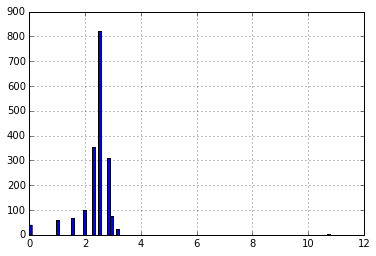

In [158]:
import networkx as nx
G = nx.Graph(edges)

# write gml file
file_name = "edges_0.5_{0.month}_{0.day}_{0.year}.gml".format(datetime.now())
nx.write_gml(G, os.path.join(graph_dir, file_name))

degree_sequence = pd.Series(nx.degree(G).values())
np.log2(degree_sequence).hist(bins=100)
#degree_sequence.hist(bins=100)



In [109]:
import igraph
#g = igraph.Graph.Read_GML(os.path.join(graph_dir, file_name))
g = igraph.Graph()

AttributeError: 'module' object has no attribute 'Graph'

In [96]:
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from sklearn import preprocessing

import itertools

import pandas.io.sql as psql
import pymysql as mdb

from datetime import datetime
from igraph import *

#g = Graph.Read_GML(os.path.join(graph_dir, file_name))
g = Graph.Read_GML('/Users/binxiang/Desktop/Insight/Week 3/graph/edges_0.5_7_25_2015.gml')
#file_name = "fastcommunity_clustering_edges_0.5_{0.month}_{0.day}_{0.year}.csv".format(datetime.now())
#print os.path.join(graph_dir, file_name)
dendrogram = g.community_fastgreedy()
clusters = dendrogram.as_clustering()
membership = clusters.membership

clustering = []
n_items = []
for i, cluster in enumerate(clusters):
    n_items.append(len(cluster))
    for node in cluster:
        clustering.append((g.vs[node]['label'], i))

clustering = pd.DataFrame(clustering)
#file_name = "fastcommunity_clustering_edges_0.5_{0.month}_{0.day}_{0.year}.csv".format(datetime.now())
file_name = '/Users/binxiang/Desktop/Insight/Week 3/graph/fastcommunity_clustering_edges_0.5_7_25_2015.csv'
#clustering.to_csv(os.path.join(graph_dir, file_name))
clustering.to_csv(file_name)

n_items = pd.Series(n_items)
n_items.plot('bar')
plt.title("Cluster Size")
plt.savefig('/Users/binxiang/Desktop/Insight/Week 3/figure/fastcommunity_cluster_size.jpg')


/Users/binxiang/Desktop/Insight/Week 3/figure/fastcommunity_cluster_size.jpg
